<a href="https://colab.research.google.com/github/barkhahbpp/sistem-cerdas/blob/main/bert_small_L6_H512_A8_userstory_classification_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Install Dependencies #

In [1]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing instal

In [2]:
!pip install pyyaml h5py

# 2 Data #

## 2.1 Loading Data ##

In [3]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)

2.15.0


In [4]:
dataseturl = 'https://raw.githubusercontent.com/barkhahbpp/deepsedataset/main/sp_dataset/marked_data/moodle.csv'
userstory_df = pd.read_csv(dataseturl)
userstory_df

,issuekey,title,description,storypoint,split_mark
0,MDL-1626,Forum: Per-discussion subscription,I am finding that my inbox is absolutely flood...,100,train
1,MDL-3714,Forum: Reply by e-mail,How about the ability to post to the forums vi...,100,train
2,MDL-5583,allow teachers to specify certain fields in da...,"When creating a database, allow the teacher to...",20,train
3,MDL-8501,Forum: proceed to next thread link,Please put a link to jump to the next thread i...,20,train
4,MDL-10115,A use profile's course list is arbitarily limi...,"When viewing a user's profile, if the list of ...",13,train
...,...,...,...,...,...
1161,MDL-54984,Final deprecation / removal of MUC stuff depre...,"From [~mr-russ], in devs chat: {quote} As ...",1,test
1162,MDL-54988,Final deprecation of methods from lib/modinfol...,"I found is_user_access_restricted_by_group(), ...",1,test
1163,MDL-55066,Create a script to compare all grades for a 57...,Currently the upgrade step for checking if a c...,2,test
1164,MDL-55126,Deprecated get_records_csv() and put_records_c...,While searching for php 7.1 incompatible code ...,1,test


In [5]:
userstory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issuekey     1166 non-null   object
 1   title        1166 non-null   object
 2   description  1166 non-null   object
 3   storypoint   1166 non-null   int64 
 4   split_mark   1166 non-null   object
dtypes: int64(1), object(4)
memory usage: 45.7+ KB


## 2.2 Explanatory Data Analisys ##

We explore descriptive statistic of dataset according story point value.

In [6]:
import seaborn as sns

pivoting_SP = userstory_df.groupby('storypoint').agg('count')['issuekey']
spoint = np.unique(userstory_df['storypoint'], axis=0)

In [7]:
pivoting_SP.describe().transpose()

count     16.000000
mean      72.875000
std       71.514917
min        1.000000
25%        1.000000
50%       64.500000
75%      122.500000
max      182.000000
Name: issuekey, dtype: float64

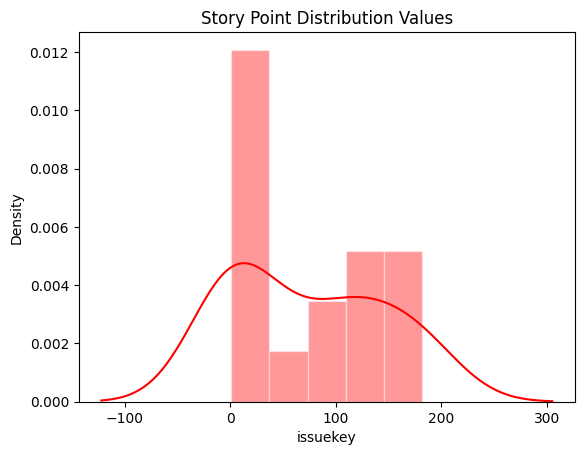

In [8]:
axes = plt.axes()
sns.histplot(pivoting_SP.map(lambda x: np.mean(x)), ax=axes, color="red", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))

axes.set_title("Story Point Distribution Values")
plt.show()

### 2.2.1 Splitting Strategy Overview

Overviewing split strategy according to dataset. Dataset author split dataset into three category split marks. first, test set, second, train set and third, validation set.

In [9]:
split_strategy = userstory_df.groupby('split_mark').agg('count')
split_strategy['sum'] = split_strategy['issuekey'].sum()
split_strategy['percent'] = (split_strategy['issuekey']/split_strategy['issuekey'].sum()*100)

split_strategy['datacount'] = split_strategy['issuekey']
split_strategy = split_strategy.drop(['issuekey',	'title',	'description',	'storypoint'], axis=1)
split_strategy

,sum,percent,datacount
split_mark,,,
test,1166,20.068611,234
train,1166,59.948542,699
val,1166,19.982847,233


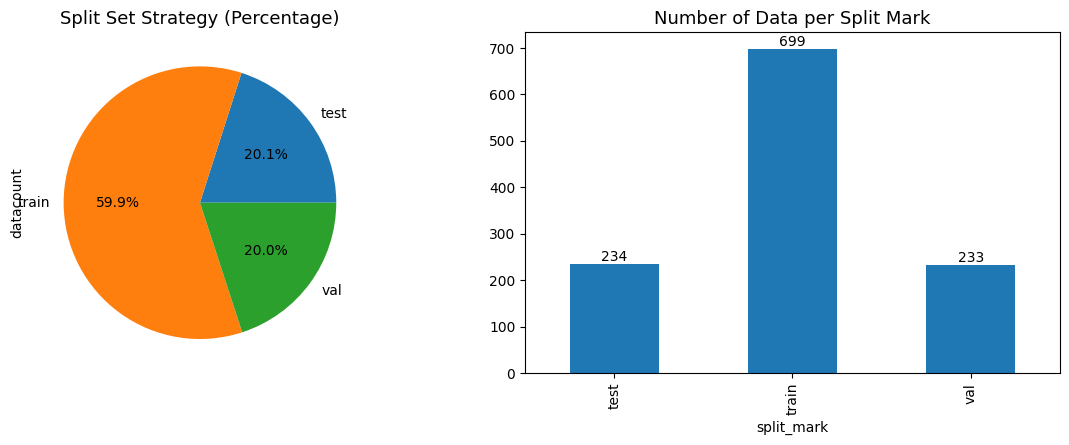

In [10]:
# Split Strategy Overview
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
plt.tight_layout()

split_strategy['datacount'].plot(ax=axes[0],kind="pie", autopct="%.1f%%")
split_strategy['datacount'].plot(ax=axes[1],kind="bar")

for container in axes[1].containers:
  axes[1].bar_label(container)

axes[0].set_title('Split Set Strategy (Percentage)', fontsize=13)
axes[1].set_title('Number of Data per Split Mark', fontsize=13)

plt.show()
# fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

### 2.2.2 Descriptive Analysis of Dataset ###

Generate descriptive statistic of dataset. Information about number of character and number of token from dataset will be calculated and evaluated

In [11]:
# calculate number of token and character from the text
# number of character
userstory_df['numofchars'] = userstory_df['title'].str.len()

# number of word tokens
userstory_df['numofwords'] = userstory_df['title'].str.split().map(lambda x: len(x))
userstory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issuekey     1166 non-null   object
 1   title        1166 non-null   object
 2   description  1166 non-null   object
 3   storypoint   1166 non-null   int64 
 4   split_mark   1166 non-null   object
 5   numofchars   1166 non-null   int64 
 6   numofwords   1166 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 63.9+ KB


In [12]:
userstory_df

,issuekey,title,description,storypoint,split_mark,numofchars,numofwords
0,MDL-1626,Forum: Per-discussion subscription,I am finding that my inbox is absolutely flood...,100,train,34,3
1,MDL-3714,Forum: Reply by e-mail,How about the ability to post to the forums vi...,100,train,22,4
2,MDL-5583,allow teachers to specify certain fields in da...,"When creating a database, allow the teacher to...",20,train,73,11
3,MDL-8501,Forum: proceed to next thread link,Please put a link to jump to the next thread i...,20,train,34,6
4,MDL-10115,A use profile's course list is arbitarily limi...,"When viewing a user's profile, if the list of ...",13,train,85,15
...,...,...,...,...,...,...,...
1161,MDL-54984,Final deprecation / removal of MUC stuff depre...,"From [~mr-russ], in devs chat: {quote} As ...",1,test,58,10
1162,MDL-54988,Final deprecation of methods from lib/modinfol...,"I found is_user_access_restricted_by_group(), ...",1,test,52,6
1163,MDL-55066,Create a script to compare all grades for a 57...,Currently the upgrade step for checking if a c...,2,test,72,13
1164,MDL-55126,Deprecated get_records_csv() and put_records_c...,While searching for php 7.1 incompatible code ...,1,test,50,4


In [13]:
userstory_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
storypoint,1166.0,15.538593,21.645639,1.0,3.0,8.0,20.0,100.0
numofchars,1166.0,56.014580,19.981080,15.0,43.0,53.0,67.0,158.0
numofwords,1166.0,8.596055,3.376864,2.0,6.0,8.0,11.0,24.0


### 2.2.3 Distribution

Probability Distribution of number of characters data, number of words data, and story point data.

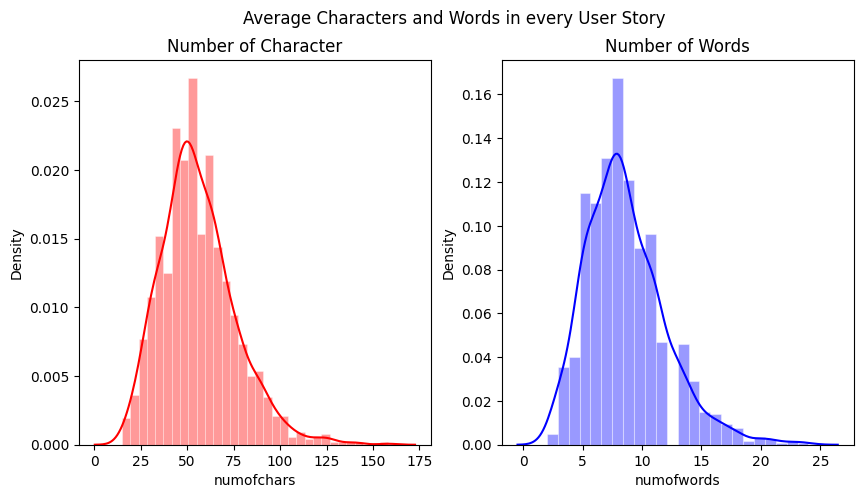

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sns.histplot(userstory_df.numofchars.map(lambda x: np.mean(x)), ax=ax1, color="red", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Number of Character')

sns.histplot(userstory_df.numofwords.map(lambda x: np.mean(x)), ax=ax2, color="blue", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Number of Words')

fig.suptitle('Average Characters and Words in every User Story')

plt.show()
# userstory_df['storypoint'].plot(kind='hist', bins=20, title='storypoint')
# plt.gca().spines[['top', 'right',]].set_visible(False)

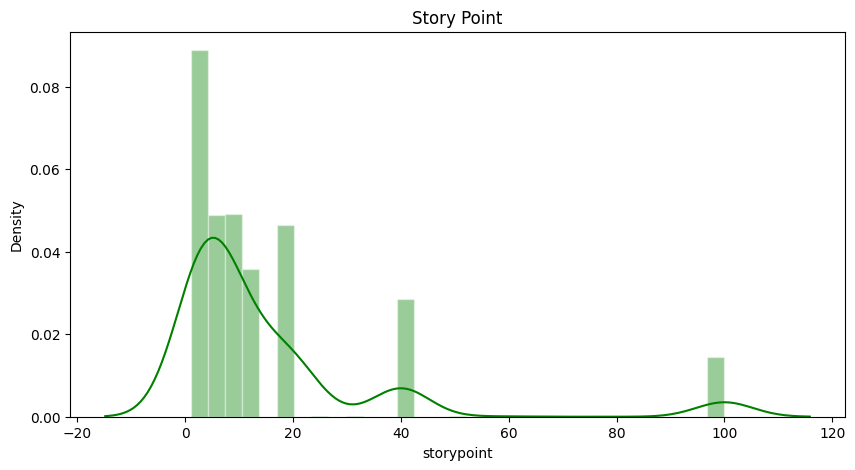

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

sns.histplot(userstory_df.storypoint.map(lambda x: np.mean(x)), ax=ax, color="green", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax.set_title('Story Point')

plt.show()

## 2.3 Splitting Dataset ##

This section will explain splitting dataset according to three splitmark category namely test, train and validation.

In [16]:
# Convert to one-hot encoded target
us_gt = pd.get_dummies(userstory_df['storypoint'])
userstory_df = pd.merge(userstory_df, us_gt, left_index=True, right_index=True)
userstory_df

,issuekey,title,description,storypoint,split_mark,numofchars,numofwords,1,2,3,...,10,13,20,24,30,40,41,52,60,100
0,MDL-1626,Forum: Per-discussion subscription,I am finding that my inbox is absolutely flood...,100,train,34,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,MDL-3714,Forum: Reply by e-mail,How about the ability to post to the forums vi...,100,train,22,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,MDL-5583,allow teachers to specify certain fields in da...,"When creating a database, allow the teacher to...",20,train,73,11,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,MDL-8501,Forum: proceed to next thread link,Please put a link to jump to the next thread i...,20,train,34,6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,MDL-10115,A use profile's course list is arbitarily limi...,"When viewing a user's profile, if the list of ...",13,train,85,15,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,MDL-54984,Final deprecation / removal of MUC stuff depre...,"From [~mr-russ], in devs chat: {quote} As ...",1,test,58,10,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1162,MDL-54988,Final deprecation of methods from lib/modinfol...,"I found is_user_access_restricted_by_group(), ...",1,test,52,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1163,MDL-55066,Create a script to compare all grades for a 57...,Currently the upgrade step for checking if a c...,2,test,72,13,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1164,MDL-55126,Deprecated get_records_csv() and put_records_c...,While searching for php 7.1 incompatible code ...,1,test,50,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
test_df = userstory_df[userstory_df['split_mark']=='test']
print("test_df dimention :"+str(test_df.shape))

train_df = userstory_df[userstory_df['split_mark']=='train']
print("train_df dimention :"+str(train_df.shape))

val_df = userstory_df[userstory_df['split_mark']=='val']
print("val_df dimention :"+str(val_df.shape))

test_df.columns

test_df dimention :(234, 23)
train_df dimention :(699, 23)
val_df dimention :(233, 23)


Index([   'issuekey',       'title', 'description',  'storypoint',
        'split_mark',  'numofchars',  'numofwords',             1,
                   2,             3,             4,             5,
                   8,            10,            13,            20,
                  24,            30,            40,            41,
                  52,            60,           100],
      dtype='object')

Decode Storypoint to binary value for storypoint classes

In [18]:
train_gt = train_df.drop(['issuekey','title', 'description', 'storypoint', 'split_mark', 'numofchars', 'numofwords'], axis=1)
test_gt = test_df.drop(['issuekey','title', 'description', 'storypoint', 'split_mark', 'numofchars', 'numofwords'], axis=1)
val_gt = val_df.drop(['issuekey','title', 'description', 'storypoint', 'split_mark', 'numofchars', 'numofwords'], axis=1)

### 2.3.1 Distribution of Number of Characters of Every Dataset ###

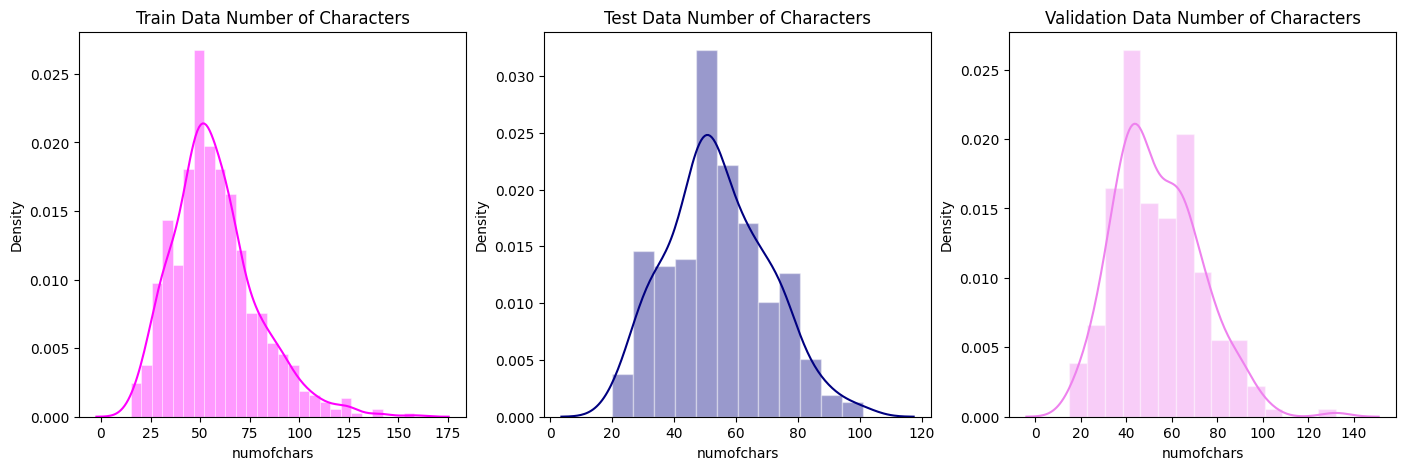

In [19]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.numofchars.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Characters')

sns.histplot(test_df.numofchars.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Characters')

sns.histplot(val_df.numofchars.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Characters')

plt.show()

### 2.3.2 Distribution of Number of Words of Every Dataset ###

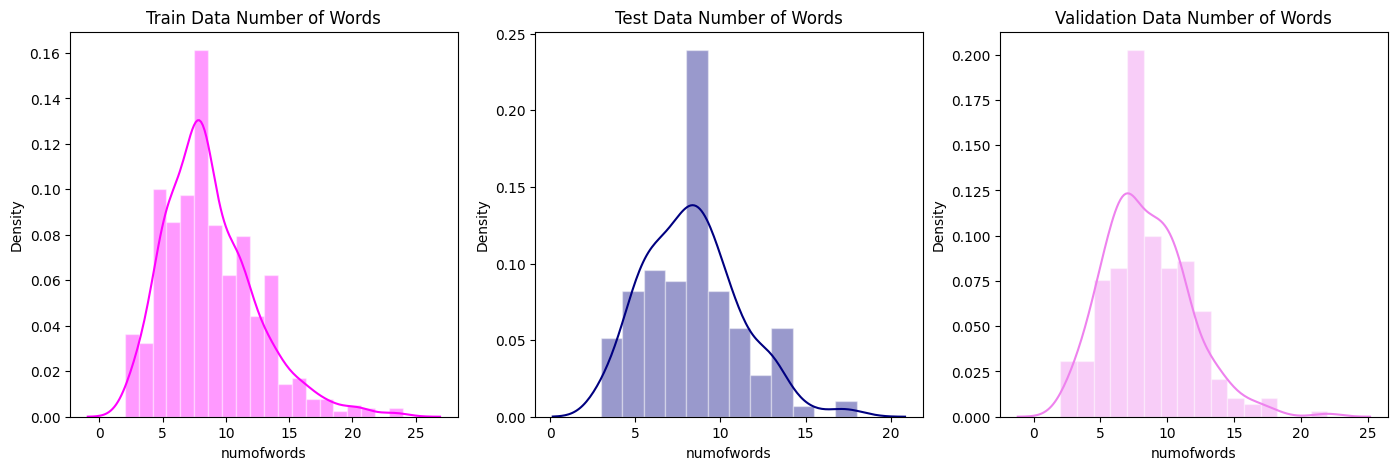

In [20]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.numofwords.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Words')

sns.histplot(test_df.numofwords.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Words')

sns.histplot(val_df.numofwords.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Words')

plt.show()

### 2.3.3 Distribution of Number of Story Point of Every Dataset ###

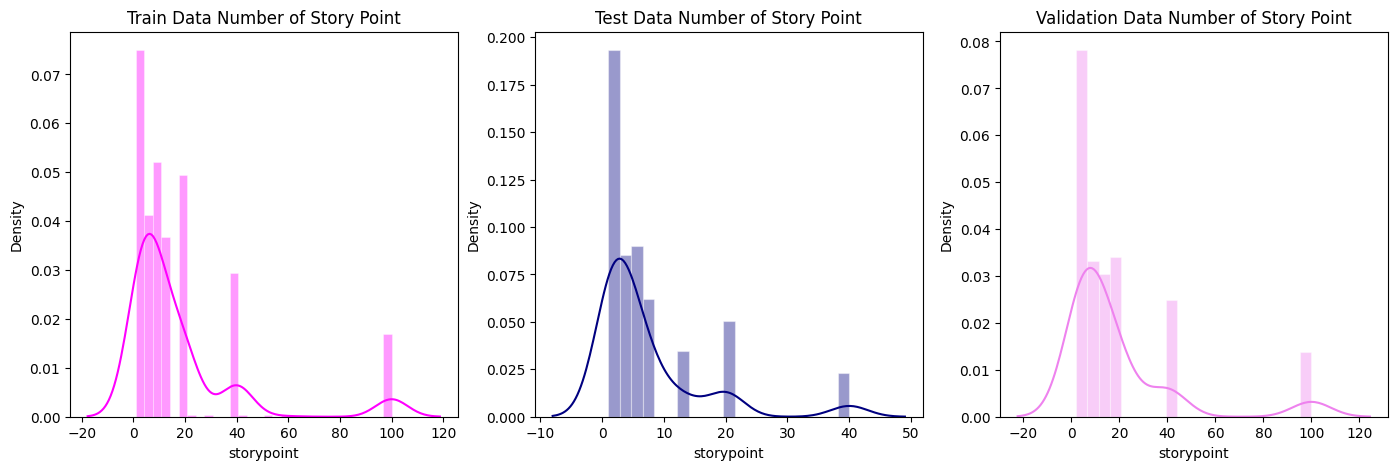

In [21]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.storypoint.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Story Point')

sns.histplot(test_df.storypoint.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Story Point')

sns.histplot(val_df.storypoint.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Story Point')

plt.show()

In [22]:
pivoting_tr = train_df.groupby('storypoint').agg('count')['issuekey']
pivoting_ts = test_df.groupby('storypoint').agg('count')['issuekey']
pivoting_vl = val_df.groupby('storypoint').agg('count')['issuekey']

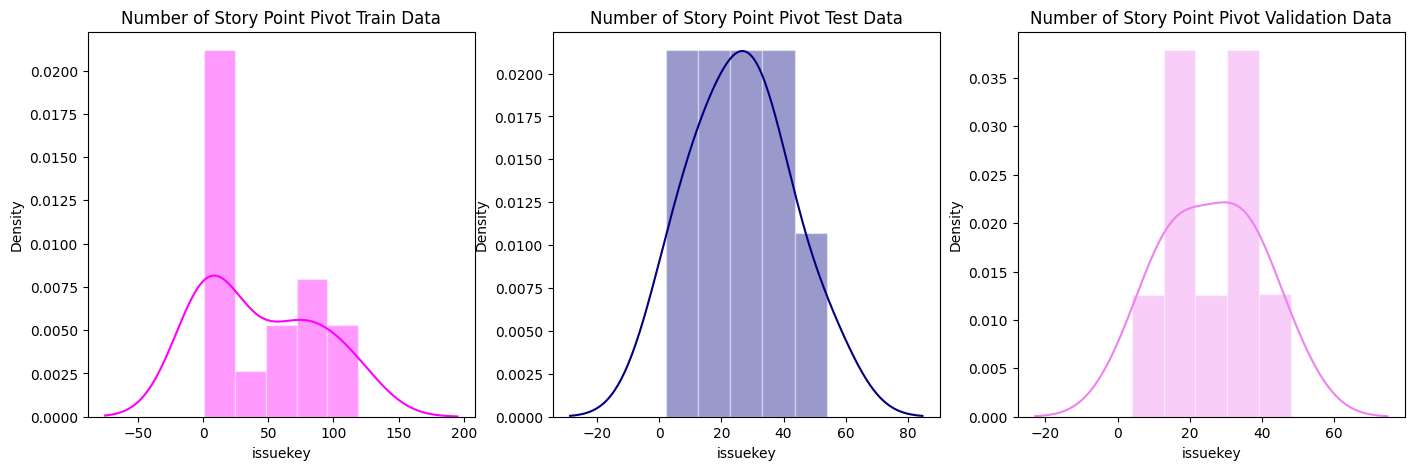

In [23]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(pivoting_tr.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Number of Story Point Pivot Train Data')

sns.histplot(pivoting_ts.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Number of Story Point Pivot Test Data')

sns.histplot(pivoting_vl.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Number of Story Point Pivot Validation Data')

plt.show()

# 3 Model #

## 3.1 Build Small BERT Model ##

In [24]:
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import optimizers

In [25]:
# preprocess_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
# encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4'

preprocess_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-6-h-512-a-8/versions/2'

# Loading Preprocessor and Encoder Model
preprocessor = hub.KerasLayer(preprocess_url)
encoder = hub.KerasLayer(encoder_url, trainable=True)


In [43]:
# BERT Model
text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
encoder_inputs = preprocessor(text_input_layer)
outputs = encoder(encoder_inputs)

# Multilayer Perceptron Model
layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden1')(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden2')(layer)
layer = tf.keras.layers.Dense(128, activation='sigmoid', name='hidden3')(layer)
layer = tf.keras.layers.Dropout(0.2, name="dropout2")(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden4')(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden5')(layer)
layer = tf.keras.layers.Dense(128, activation='sigmoid', name='hidden6')(layer)
layer = tf.keras.layers.Dense(16, activation='sigmoid', name='output')(layer)

#Final Model
model = tf.keras.Model(inputs=[text_input_layer], outputs=[layer])

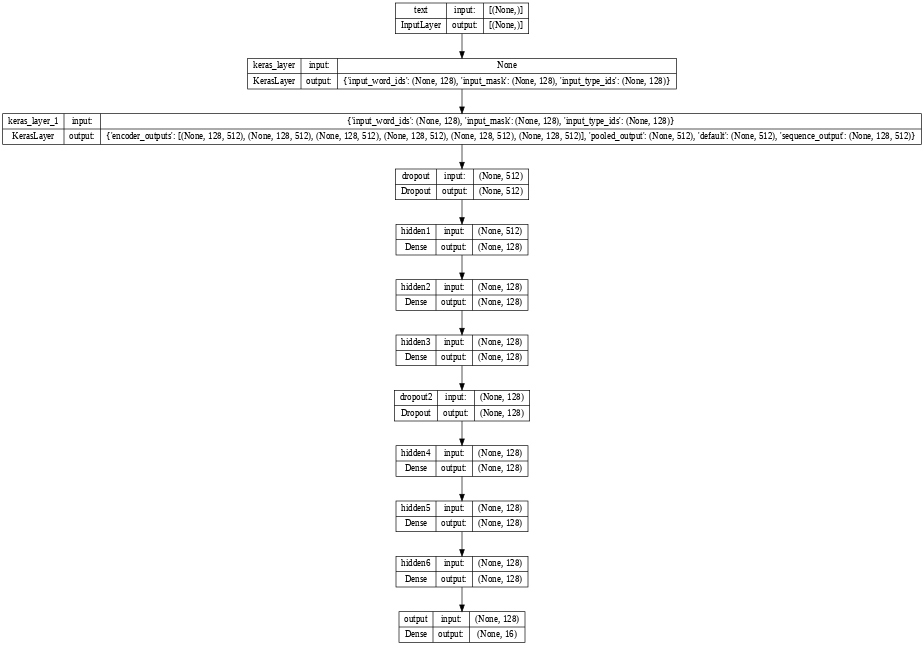

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=48)

## 3.2 Define Model Metric ##

In [45]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

initial_rate = 0.1
end_rate = 0.001
decay_steps = 10000

learning_rate_fn = optimizers.schedules.PolynomialDecay(
    initial_rate,
    decay_steps,
    end_rate,
    power=0.5)

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),
#               metrics=METRICS)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(0.01),
              metrics=METRICS)

## 3.3 Train Model

### 3.3.1 Fit Model ###

In [41]:
pwd

'/content'

In [46]:
checkpoint_path = "bert_small_L6_H256_A4_userstory_exercise/Checkpoint-{epoch:02d}-{accuracy:.02f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_df['title'], train_gt, epochs=100, batch_size=25, verbose=1, validation_data=(val_df['title'], val_gt), callbacks=[checkpoint])

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5922 - precision: 0.0872 - recall: 0.5837
Epoch 1: loss improved from inf to 0.67045, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-01-0.59.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 64s 2s/step - loss: 0.6704 - accuracy: 0.5922 - precision: 0.0872 - recall: 0.5837 - val_loss: 0.6206 - val_accuracy: 0.6899 - val_precision: 0.1039 - val_recall: 0.5193
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.7415 - precision: 0.1297 - recall: 0.5494
Epoch 2: loss improved from 0.67045 to 0.57158, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-02-0.74.h5
28/28 [==============================] - 60s 2s/step - loss: 0.5716 - accuracy: 0.7415 - precision: 0.1297 - recall: 0.5494 - val_loss: 0.5354 - val_accuracy: 0.7951 - val_precision: 0.1202 - val_recall: 0.3605
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.8577 - precision: 0.1307 - recall: 0.2260
Epoch 3: loss improved from 0.57158 to 0.49862, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-03-0.86.h5
28/28 [==============================] - 59s 2s/step - loss:

In [47]:
# model save
model.save('bert_small_L6_H256_A4_userstory_classifier.keras')

### 3.3.2 Training Curve ###

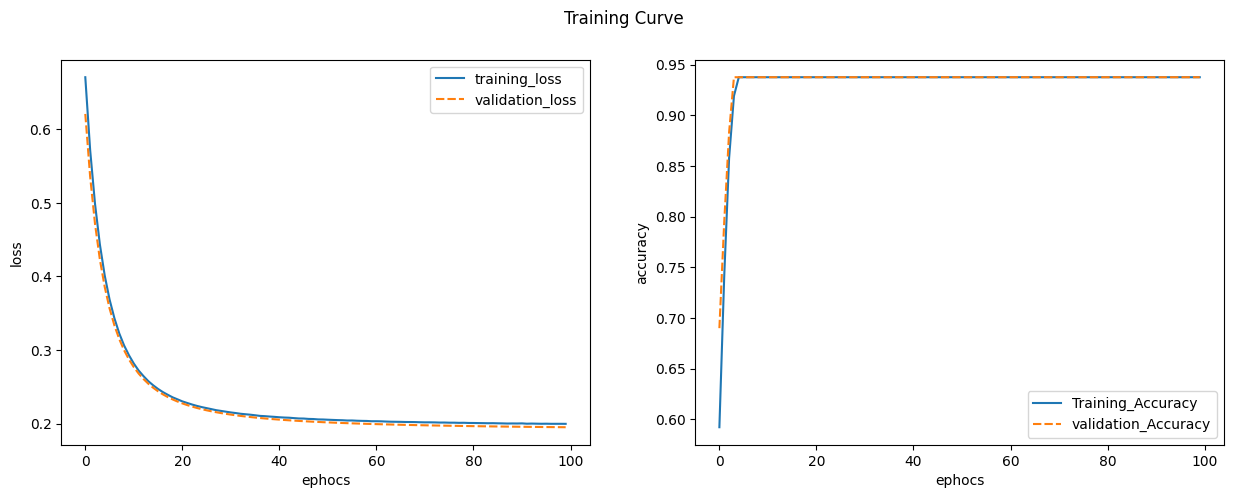

In [48]:
fig, (axs1, axs2) = plt.subplots(1,2,figsize=(15,5))

loss = {
    'training_loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
}

rmse = {
    'Training_Accuracy': history.history['accuracy'],
    'validation_Accuracy': history.history['val_accuracy']
}

sns.lineplot(loss, ax=axs1, linestyle='solid')
sns.lineplot(rmse, ax=axs2, linestyle='solid')
axs1.set_xlabel('ephocs')
axs2.set_xlabel('ephocs')
axs1.set_ylabel('loss')
axs2.set_ylabel('accuracy')
fig.suptitle("Training Curve")

plt.show()

## 3.4 Predict Story Point ##

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(train_df['title'])

pred

22/22 [==============================] - 17s 781ms/step


array([[0.03148736, 0.10035691, 0.0917265 , ..., 0.01354097, 0.01215231,
        0.05462781],
       [0.03148089, 0.10035525, 0.09163263, ..., 0.01353606, 0.012145  ,
        0.05457405],
       [0.03148812, 0.1003925 , 0.09159736, ..., 0.01353542, 0.01214277,
        0.05451728],
       ...,
       [0.03147563, 0.10037439, 0.09162307, ..., 0.01352824, 0.0121471 ,
        0.05455438],
       [0.03151648, 0.10031445, 0.09174852, ..., 0.01356052, 0.01216629,
        0.05461204],
       [0.03148472, 0.10037247, 0.09160437, ..., 0.01354134, 0.01214688,
        0.05452516]], dtype=float32)

In [56]:
pred = np.where(pred > 0.5, 1, 0)
pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

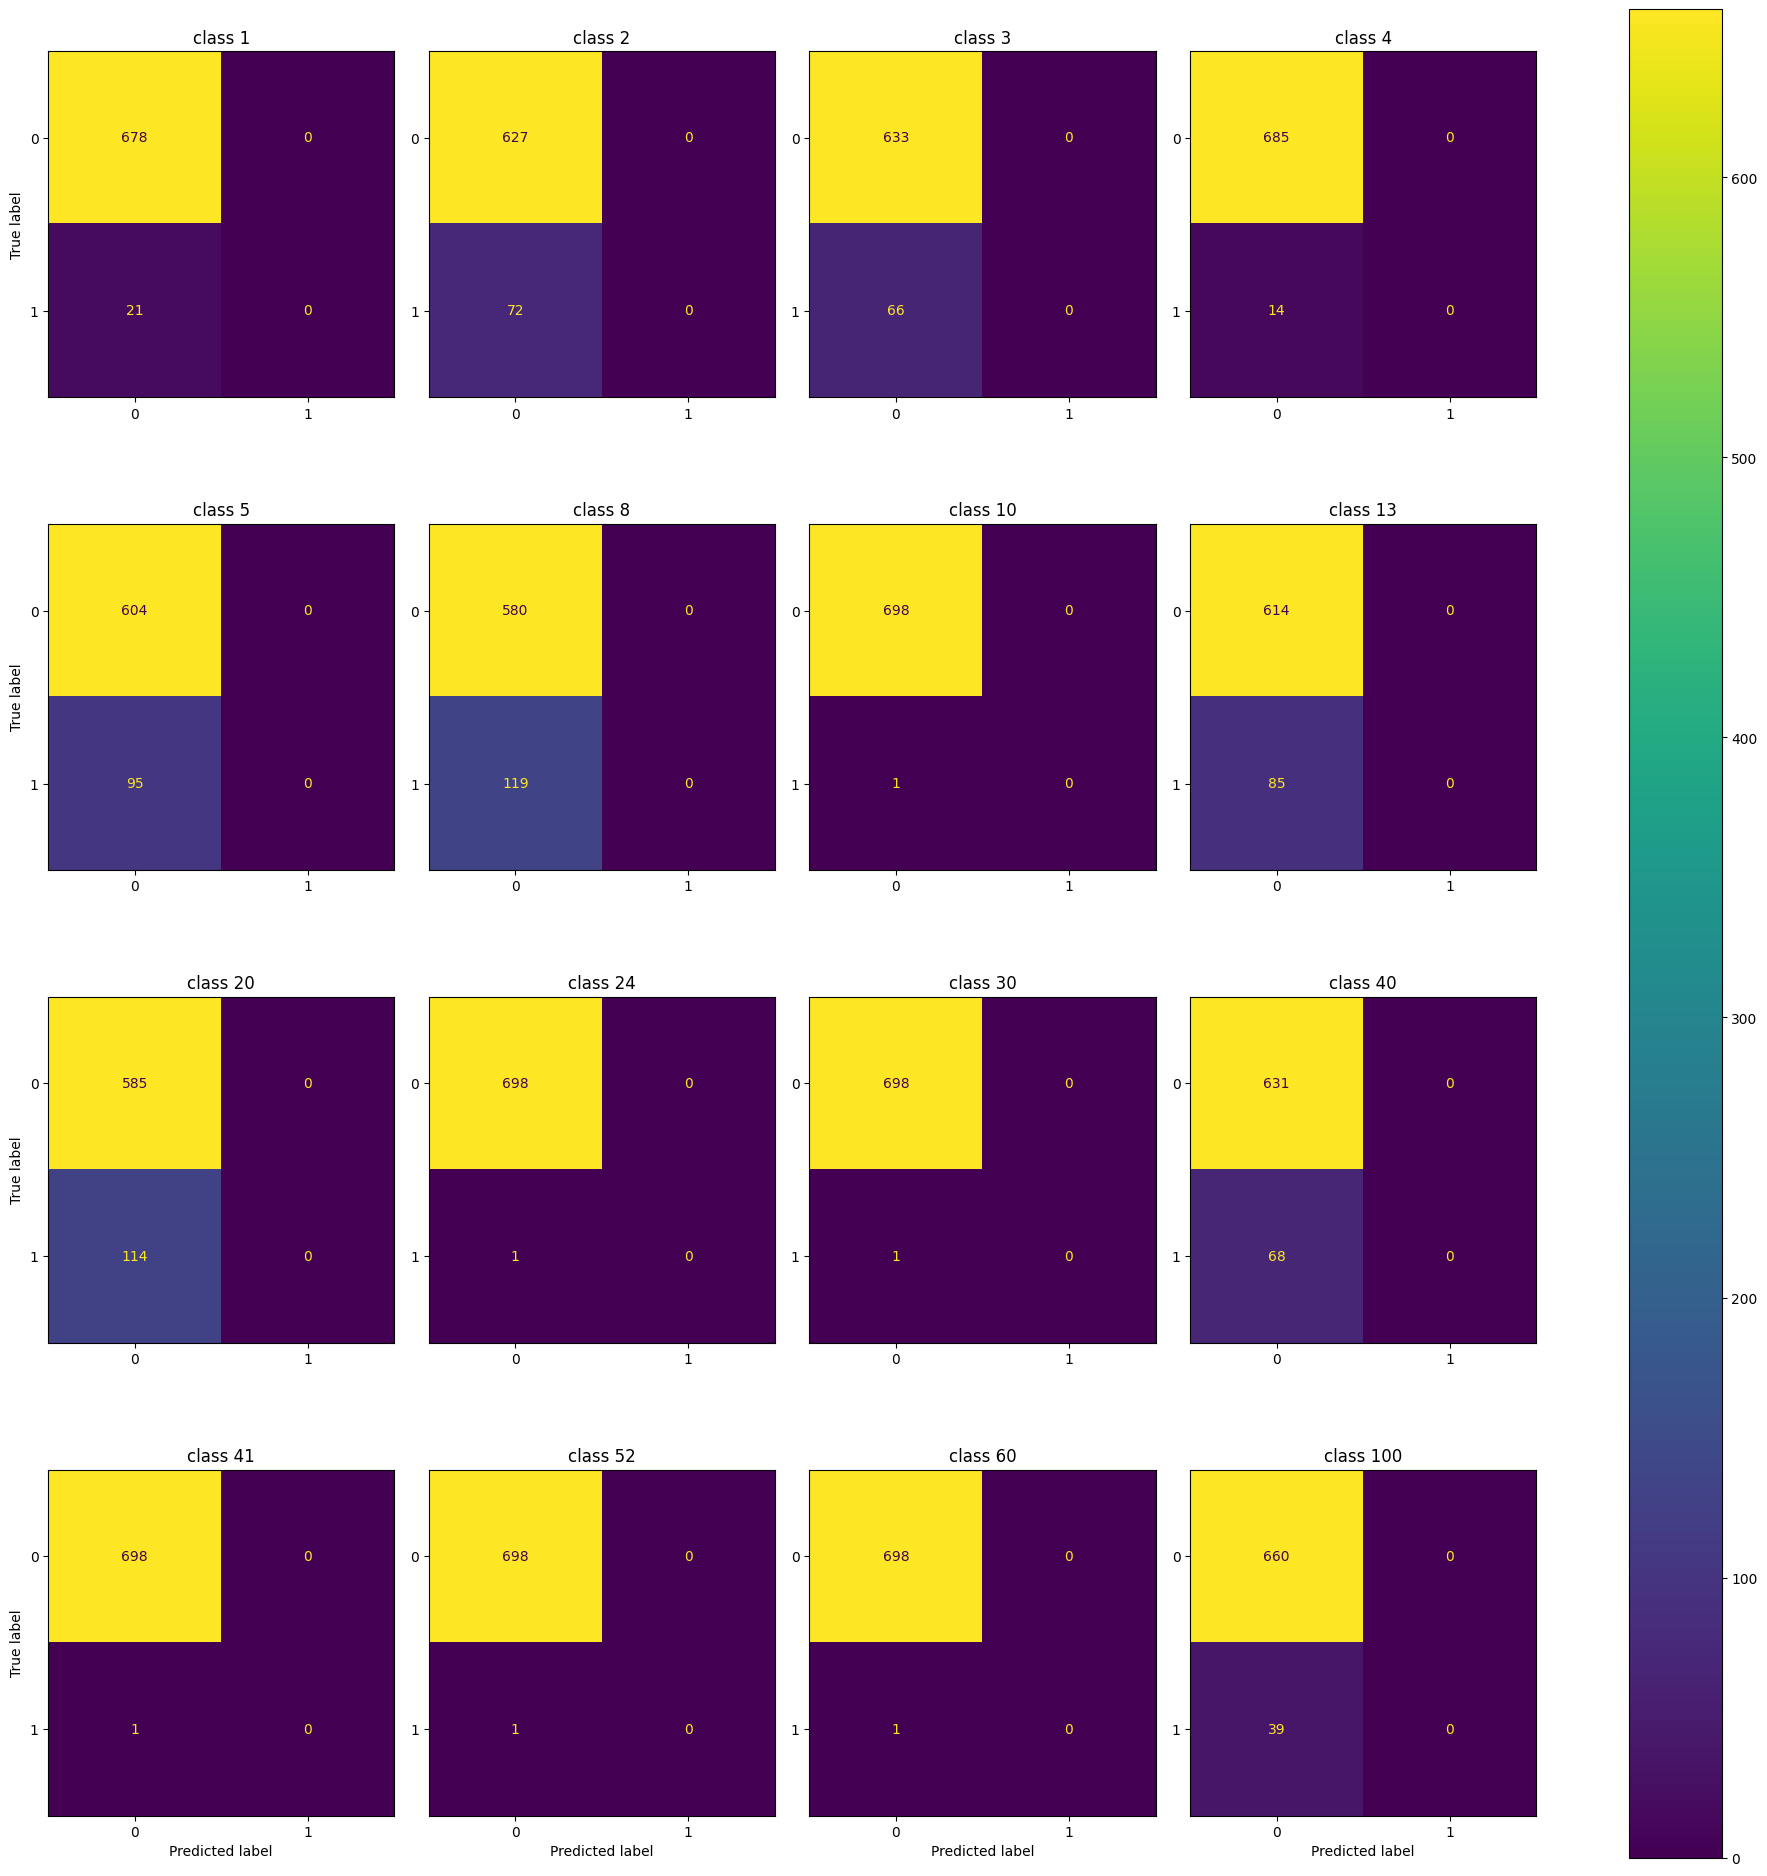

In [57]:
cmtrices = multilabel_confusion_matrix(train_gt, pred)

# for cmtrix in cmtrices:
#   disp = ConfusionMatrixDisplay(cmtrix)
#   disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
#   disp..set_title(f'class {i}')
#   plt.show()
f, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.ravel()

for i in range(16):
  disp = ConfusionMatrixDisplay(cmtrices[i])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(f'class {spoint[i]}')
  if i<12:
      disp.ax_.set_xlabel('')
  if i%4!=0:
      disp.ax_.set_ylabel('')
  disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()
# sns.heatmap(cmtrix, annot=True, fmt='d')

# plt.xlabel("Predicted")
# plt.ylabel("Truth")

# plt.show()

# test_gt